In [ ]:
import numpy as np
import keras
import tensorflow as tf
from   keras.datasets import mnist
from   keras.models import Sequential, Model
from   keras.layers import Dense, Input
from   keras import optimizers
from   keras.optimizers import Adam
from IPython.display import Image
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
from   tqdm import tqdm
import time
import cv2

## Augment the images to create a larger dataset

In [4]:
path = "data/"

In [ ]:
datagen = ImageDataGenerator(
                    rotation_range=90,
                    horizontal_flip=True,
                    vertical_flip=True,
                    width_shift_range=45.0,
                    height_shift_range=45.0)

Generate the augmented images twice with the same seed, so that we have **paired data points (images) with the same transformations**:

In [ ]:
img = load_img(path + "domain_adaptation_dogcat/dog.jpg")
x = img_to_array(img) # convert it into an array
x = x.reshape((1, ) + x.shape)       # Reshape the input image
n = 1000     # set n to the number of augmented images you want
i = 1
# generate n new augmented images and store them in the given folder that exists
for batch in datagen.flow(x, batch_size = 1, save_to_dir = path + "domain_adaptation_dog", save_format ='jpg', seed=42):
    if i > n-1:
        break
    i += 1

In [ ]:
img = load_img(path + "domain_adaptation_dogcat/cat.jpg")
x = img_to_array(img) # convert it into an array
x = x.reshape((1, ) + x.shape)       # Reshape the input image
n = 1000     # set n to the number of augmented images you want
i = 1
# generate n new augmented images and store them in the given folder that exists
for batch in datagen.flow(x, batch_size = 1, save_to_dir = path + "domain_adaptation_cat", save_format ='jpg', seed=42):
    if i > n-1:
        break
    i += 1

## Import the augmented images

In [6]:
# import input (dog) images
input_img_data=[]
input_path = path + "domain_adaptation_dog/"
input_files=os.listdir(input_path)
input_files.sort()
# read all images in the folder (the pre-generated augmented versions)
for i in tqdm(input_files):
    img=cv2.imread(input_path+i)[:,:,::-1]
    img=cv2.resize(img,(256, 256))
    input_img_data.append(img_to_array(img))

100%|██████████| 958/958 [00:11<00:00, 84.57it/s] 


In [7]:
# import output (cat) images
output_img_data=[]
output_path = path + "domain_adaptation_cat/"
output_files=os.listdir(output_path)
output_files.sort()
# read all images in the folder (the pre-generated augmented versions)
for i in tqdm(output_files):
    img=cv2.imread(output_path+i)[:,:,::-1]
    img=cv2.resize(img,(256, 256))
    output_img_data.append(img_to_array(img))

100%|██████████| 958/958 [00:14<00:00, 64.38it/s]


In [8]:
# import noisy input (dog) images
noisy_input_img_data=[]
input_path = path + "domain_adaptation_dog/"
input_files=os.listdir(input_path)
input_files.sort()
# read all images in the folder (the pre-generated augmented versions)
for i in tqdm(input_files):
    img=cv2.imread(input_path+i)[:,:,::-1]
    img=cv2.resize(img,(256, 256))
    # https://stackoverflow.com/questions/43382045/keras-realtime-augmentation-adding-noise-and-contrast
    noise = np.random.normal(0, 50, img.shape)
    img = img + noise
    img = np.clip(img, 0., 255.)
    noisy_input_img_data.append(img_to_array(img))

100%|██████████| 958/958 [00:17<00:00, 53.63it/s]


In [9]:
input_img_array = np.reshape(input_img_data, (len(input_img_data), 256, 256, 3))
input_img_array = input_img_array.astype('float32') / 255. # normalize
output_img_array = np.reshape(output_img_data, (len(output_img_data), 256, 256, 3))
output_img_array = output_img_array.astype('float32') / 255. # normalize
noisy_input_img_array = np.reshape(noisy_input_img_data, (len(noisy_input_img_data), 256, 256, 3))
noisy_input_img_array = noisy_input_img_array.astype('float32') / 255. # normalize

In [10]:
test_img_data=[]
test_img=cv2.imread(path + "domain_adaptation_dogcat/dog.jpg")[:,:,::-1]
test_img=cv2.resize(test_img,(256, 256))
test_img_data.append(img_to_array(test_img))
test_img_array = np.reshape(test_img_data, (len(test_img_data), 256, 256, 3))
test_img_array = test_img_array.astype('float32') / 255. # normalize

In [5]:
noisy_test_img_data=[]
noisy_test_img=cv2.imread(path + "domain_adaptation_dogcat/dog.jpg")[:,:,::-1]
noisy_test_img=cv2.resize(noisy_test_img,(256, 256))
noise = np.random.normal(0, 50, noisy_test_img.shape)
noisy_test_img = noisy_test_img + noise
noisy_test_img = np.clip(noisy_test_img, 0., 255.)
noisy_test_img_data.append(img_to_array(noisy_test_img))
noisy_test_img_array = np.reshape(noisy_test_img_data, (len(noisy_test_img_data), 256, 256, 3))
noisy_test_img_array = noisy_test_img_array.astype('float32') / 255.

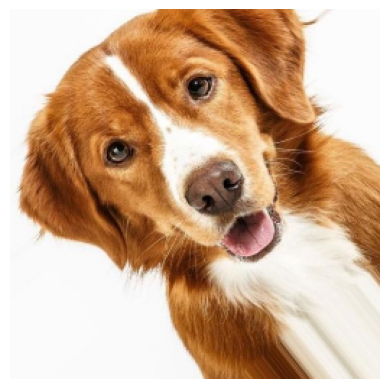

In [12]:
plt.imshow(input_img_array[0])
plt.axis(False);

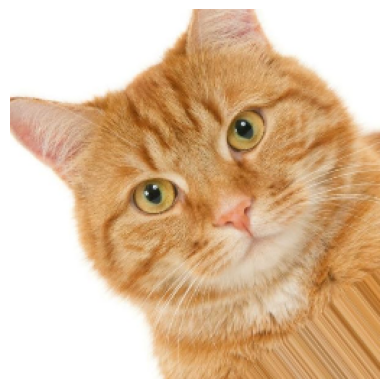

In [14]:
plt.imshow(output_img_array[0])
plt.axis(False);

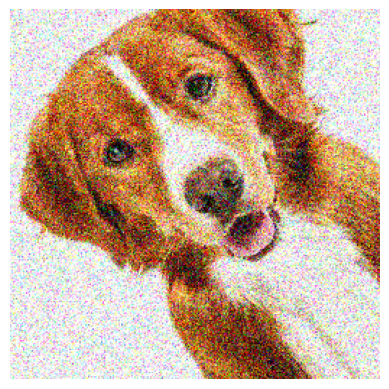

In [13]:
plt.imshow(noisy_input_img_array[0])
plt.axis(False);

In [15]:
input_img_array.shape

(958, 256, 256, 3)

In [16]:
noisy_input_img_array.shape

(958, 256, 256, 3)

In [17]:
output_img_array.shape

(958, 256, 256, 3)

## Create and train the autoencoder model

### Fit a model that encodes and decodes the same images:

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='elu', padding='same', input_shape=(256, 256, 3))) # go from 3 to 32 channels
model1.add(MaxPooling2D((2, 2), padding='same')) # reduce the size of image to 128x128 pixels
model1.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
model1.add(MaxPooling2D((2, 2), padding='same')) # reduce to 64x64 pixels
model1.add(Conv2D(32, (3, 3), activation='elu', padding='same'))

model1.add(UpSampling2D((2, 2))) # increase to 128x128 pixels
model1.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
model1.add(UpSampling2D((2, 2))) # increase to 256x256 pixels
model1.add(Conv2D(3, (3, 3), activation='elu', padding='same')) # decrease to 3 channels

In [ ]:
model1.compile(optimizer="Adam", loss='mean_squared_error')
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 128, 128, 32)     

In [ ]:
model1.fit(input_img_array, input_img_array, batch_size=32, epochs=100, shuffle=True)

Epoch 1/100
30/30 [==============================] - 6s 128ms/step - loss: 0.0574
Epoch 2/100
30/30 [==============================] - 4s 120ms/step - loss: 0.0125
Epoch 3/100
30/30 [==============================] - 4s 121ms/step - loss: 0.0079
Epoch 4/100
30/30 [==============================] - 4s 124ms/step - loss: 0.0052
Epoch 5/100
30/30 [==============================] - 4s 124ms/step - loss: 0.0039
Epoch 6/100
30/30 [==============================] - 4s 121ms/step - loss: 0.0038
Epoch 7/100
30/30 [==============================] - 4s 122ms/step - loss: 0.0034
Epoch 8/100
30/30 [==============================] - 4s 129ms/step - loss: 0.0030
Epoch 9/100
30/30 [==============================] - 4s 124ms/step - loss: 0.0028
Epoch 10/100
30/30 [==============================] - 4s 123ms/step - loss: 0.0032
Epoch 11/100
30/30 [==============================] - 4s 123ms/step - loss: 0.0026
Epoch 12/100
30/30 [==============================] - 4s 130ms/step - loss: 0.0025
Epoch 13/100


1/1 [==============================] - 0s 453ms/step


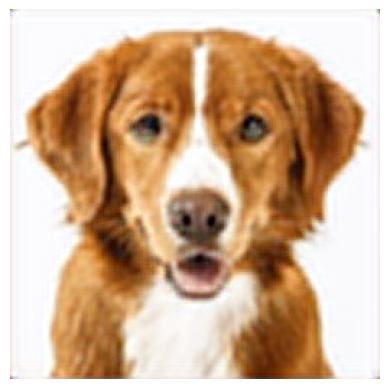

In [ ]:
pred = model1.predict(test_img_array)
plt.imshow(pred[0])
plt.axis(False);

The result is slightly blurry. When encoding and decoding exactly the same images, it is possible for the encoding to learn to simply multiply by 1, to get a "perfect" reconstruction.

### Fit a model that encodes and decode the same images, with noise added to the inputs:

In [14]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3))) # go from 3 to 32 channels
model2.add(MaxPooling2D((2, 2), padding='same')) # reduce the size of image to 128x128 pixels
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), padding='same')) # reduce to 64x64 pixels
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

model2.add(UpSampling2D((2, 2))) # increase to 128x128 pixels
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(UpSampling2D((2, 2))) # increase to 256x256 pixels
model2.add(Conv2D(3, (3, 3), activation='relu', padding='same')) # decrease to 3 channels

In [15]:
model2.compile(optimizer="Adam", loss='mean_squared_error')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 128, 128, 32)     

In [16]:
model2.fit(noisy_input_img_array, input_img_array, batch_size=32, epochs=100, shuffle=True)

Epoch 1/100
30/30 [==============================] - 7s 133ms/step - loss: 0.1665
Epoch 2/100
30/30 [==============================] - 3s 106ms/step - loss: 0.0156
Epoch 3/100
30/30 [==============================] - 3s 106ms/step - loss: 0.0064
Epoch 4/100
30/30 [==============================] - 3s 106ms/step - loss: 0.0048
Epoch 5/100
30/30 [==============================] - 3s 115ms/step - loss: 0.0041
Epoch 6/100
30/30 [==============================] - 3s 108ms/step - loss: 0.0037
Epoch 7/100
30/30 [==============================] - 3s 109ms/step - loss: 0.0034
Epoch 8/100
30/30 [==============================] - 3s 108ms/step - loss: 0.0033
Epoch 9/100
30/30 [==============================] - 3s 114ms/step - loss: 0.0032
Epoch 10/100
30/30 [==============================] - 3s 106ms/step - loss: 0.0031
Epoch 11/100
30/30 [==============================] - 3s 108ms/step - loss: 0.0030
Epoch 12/100
30/30 [==============================] - 3s 108ms/step - loss: 0.0029
Epoch 13/100


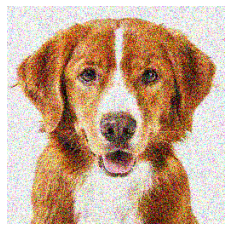

In [8]:
plt.imshow(noisy_test_img_array[0])
plt.axis(False);

1/1 [==============================] - 0s 19ms/step


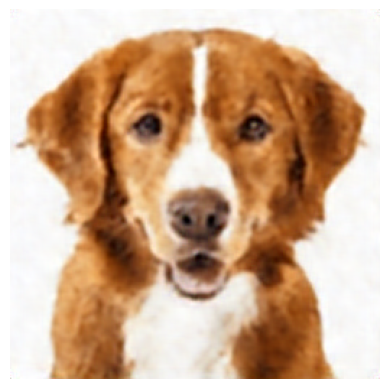

In [18]:
pred = model2.predict(noisy_test_img_array)
plt.imshow(pred[0])
plt.axis(False);

To force information loss, to force the auto encoder to actually learn a latent representation of the image, and not just multiply by 1, noise is added to the input data, but the reconstruction error is calculated from the original data without noise: error=decoder(encoder(X+noise)-X . The random noise can never be mappable to the latent space, because it is unstructured.

Here the encoder has learned to denoise - it has removed all of the noise from the noisy input image!

### Fit a model that performs domain adaptation, by encoding one image, and decoding to another.

In [18]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3))) # go from 3 to 32 channels
model3.add(MaxPooling2D((2, 2), padding='same')) # reduce the size of image to 128x128 pixels
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model3.add(MaxPooling2D((2, 2), padding='same')) # reduce to 64x64 pixels
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

model3.add(UpSampling2D((2, 2))) # increase to 128x128 pixels
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model3.add(UpSampling2D((2, 2))) # increase to 256x256 pixels
model3.add(Conv2D(3, (3, 3), activation='relu', padding='same')) # decrease to 3 channels

In [19]:
model3.compile(optimizer="Adam", loss='mean_squared_error')
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 up_sampling2d (UpSampling2  (None, 128, 128, 32)      0

In [ ]:
model3.fit(input_img_array, output_img_array, batch_size=32, epochs=300, shuffle=True)

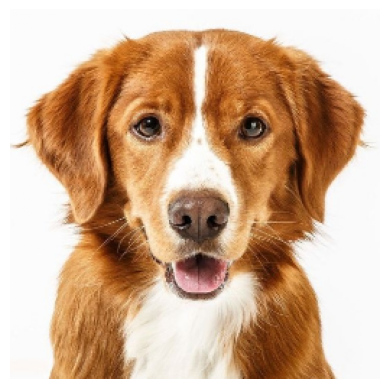

In [24]:
plt.imshow(test_img_array[0])
plt.axis(False);

1/1 [==============================] - 0s 40ms/step


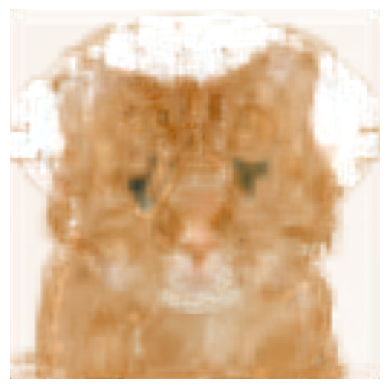

In [22]:
pred = model3.predict(test_img_array)
plt.imshow(pred[0])
plt.axis(False);

The results from the domain adaptation aren't amazing, but it does look more like a cat than a dog! What we as humans consider to be a "good" approximation - e.g. have the main features changed, like eyes and nose - is not necessarily what is important to computers. If in general the pixel values have changed to be closer in colour to the output, then to a computer, the transformation is successful.